## Saving a Cats v Dogs Model

This is a minimal example showing how to train a fastai model on Kaggle, and save it so you can use it in your app.

In [1]:
# Make sure we've got the latest version of fastai:
#!pip install -Uqq fastai

First, import all the stuff we need from fastai:

In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

/home/gchirkov/.conda/envs/fastai/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Download and decompress our dataset, which is pictures of dogs and cats:

In [3]:
path = untar_data(URLs.PETS)/'images'

We need a way to label our images as dogs or cats. In this dataset, pictures of cats are given a filename that starts with a capital letter:

In [4]:
import re
def is_cat(x): return 'cat' if x[0].isupper() else 'dog'
def breed(x): return x.rsplit("_", 1)[0]

Now we can create our `DataLoaders`:

In [5]:
dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(192))

... and train our model, a resnet18 (to keep it small and fast):

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/gchirkov/.conda/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/gchirkov/.conda/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.189068,0.042183,0.014895,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.092977,0.034710,0.011510,00:39
1,0.047341,0.015190,0.004739,00:40
2,0.023876,0.009544,0.004062,00:42


Now let's see the mistakes the model is making. To visualize this, we can create a confusion matrix:

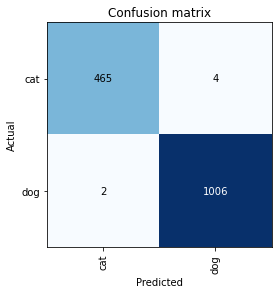

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

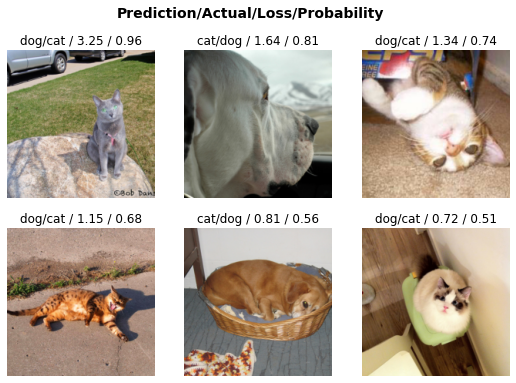

In [8]:
interp.plot_top_losses(6, nrows=2)

fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [9]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [12]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now we can export our trained `Learner`. This contains all the information needed to run the model:

In [10]:
learn.export('model.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the `/kaggle/working` folder, and you'll see `model.pkl`. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.